# Handwritten Digit and Letter Recognition with CNN (MNIST + EMNIST)
### This notebook trains a convolutional neural network (CNN) to recognize both handwritten digits (0–9) from the MNIST dataset and uppercase letters (A–Z) from the EMNIST dataset.

## Import Libraries

In [10]:
# ---------------------------
# 1. Imports
# ---------------------------
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader, ConcatDataset, Dataset

## Define Image Transforms
### MNIST: Normalize pixel values to [-1, 1].
### EMNIST: Rotate and flip images to correct orientation, then normalize.

In [19]:
# ---------------------------
# 2. Define Transforms
# ---------------------------

# MNIST transform: normalize to [-1, 1]
transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# EMNIST transform: rotate/transpose so letters are upright, then normalize
transform_emnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.transpose(1, 2).flip(1)),  # fix orientation
    transforms.Normalize((0.5,), (0.5,))
])

## Load Datasets

In [21]:
# ---------------------------
# 3. Load Datasets
# ---------------------------

# 3.1 MNIST (digits 0–9)
mnist_train = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform_mnist
)
mnist_test = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform_mnist
)

# 3.2 EMNIST Letters (labels 1–26 for A–Z)
emnist_train = torchvision.datasets.EMNIST(
    root='./data',
    split='letters',
    train=True,
    download=True,
    transform=transform_emnist
)
emnist_test = torchvision.datasets.EMNIST(
    root='./data',
    split='letters',
    train=False,
    download=True,
    transform=transform_emnist
)

## Remap Labels
### We remap the labels to avoid overlap:
### MNIST: 0–9 → stays 0–9
### EMNIST Letters: 1–26 → becomes 10–35

In [22]:
# ---------------------------
# 4. Wrap & Remap Labels
# ---------------------------

class RemappedDataset(Dataset):
    """
    Wraps an existing dataset and remaps its labels by applying:
      new_label = (orig_label + offset)   OR   new_label = (orig_label - 1 + offset)  for EMNIST letters.
    """
    def __init__(self, base_dataset, offset=0, is_emnist_letters=False):
        self.base_dataset = base_dataset
        self.offset = offset
        self.is_emnist = is_emnist_letters

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, label = self.base_dataset[idx]
        if self.is_emnist:
            # EMNIST Letters labels run 1–26; convert to 0–25, then offset
            label = (label - 1) + self.offset
        else:
            # MNIST labels are already 0–9
            label = label + self.offset
        return img, label

# For MNIST: offset = 0, is_emnist=False
mnist_train_wrapped = RemappedDataset(mnist_train, offset=0, is_emnist_letters=False)
mnist_test_wrapped  = RemappedDataset(mnist_test,  offset=0, is_emnist_letters=False)

# For EMNIST Letters: offset = 10, is_emnist=True
# (So A→0→+10 = 10, B→1→+10 = 11, …, Z→25→+10 = 35)
emnist_train_wrapped = RemappedDataset(emnist_train, offset=10, is_emnist_letters=True)
emnist_test_wrapped  = RemappedDataset(emnist_test,  offset=10, is_emnist_letters=True)



## Combine Datasets

In [23]:
# ---------------------------
# 5. Combine into ConcatDatasets
# ---------------------------

train_combined = ConcatDataset([mnist_train_wrapped, emnist_train_wrapped])
test_combined  = ConcatDataset([mnist_test_wrapped,  emnist_test_wrapped])

## Create DataLoaders

In [24]:
# ---------------------------
# 6. Create DataLoaders
# ---------------------------

batch_size = 128

train_loader = DataLoader(train_combined, batch_size=batch_size, shuffle=True,  num_workers=0)
test_loader  = DataLoader(test_combined,  batch_size=batch_size, shuffle=False, num_workers=0)

## Define the CNN Model

In [25]:
# ---------------------------
# 7. Define CNN Model (36-way output)
# ---------------------------

class CNN36(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # [1×28×28] → [32×28×28]
            nn.ReLU(),
            nn.MaxPool2d(2),                              # → [32×14×14]
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # → [64×14×14]
            nn.ReLU(),
            nn.MaxPool2d(2),                              # → [64×7×7]
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),                                 # → [64*7*7 = 3136]
            nn.Dropout(0.5),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 36)                            # 10 digits + 26 letters = 36 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

## Initialize Model, Loss & Optimizer

In [26]:
# ---------------------------
# 8. Initialize Model, Loss, Optimizer
# ---------------------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN36().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training Loop

In [27]:
# ---------------------------
# 9. Training Loop
# ---------------------------

epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)                   # shape: [batch_size, 36]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}  —  Training Loss: {avg_loss:.4f}")

Epoch 1/5  —  Training Loss: 0.4797
Epoch 2/5  —  Training Loss: 0.2369
Epoch 3/5  —  Training Loss: 0.1991
Epoch 4/5  —  Training Loss: 0.1778
Epoch 5/5  —  Training Loss: 0.1630


## Evaluate on Test Set

In [28]:
# ---------------------------
# 10. Evaluation on Test Set
# ---------------------------

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"\nTest Accuracy (digits + letters): {accuracy:.2f}%")


Test Accuracy (digits + letters): 95.29%


## Helper: Map Class Index to Character

In [29]:
# ---------------------------
# 11. Helper: Map Class Index to Character
# ---------------------------

def index_to_char(idx):
    """
    0–9  → '0'–'9'
    10–35 → 'A'–'Z'
    """
    if 0 <= idx <= 9:
        return str(idx)
    else:
        return chr(idx - 10 + ord('A'))

## Visualize Predictions

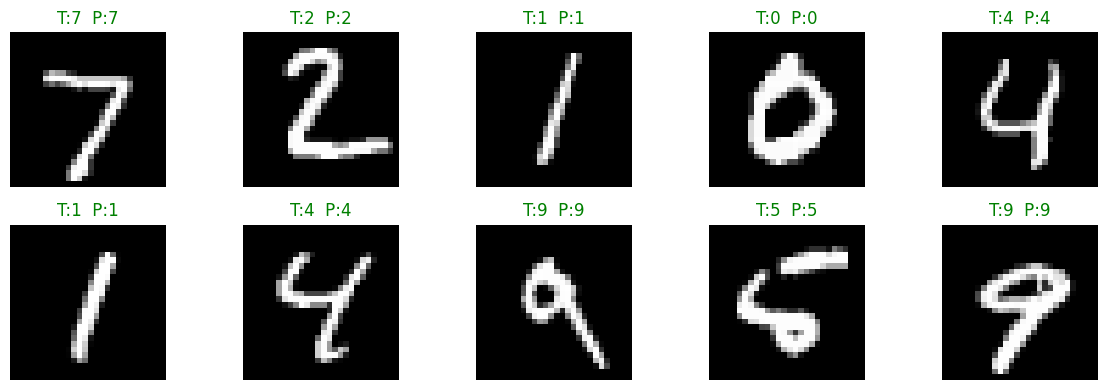

In [32]:
# ---------------------------
# 12. Visualize Some Predictions
# ---------------------------

def show_predictions(num_samples=10):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(12, 4))
    for i in range(num_samples):
        plt.subplot(2, num_samples//2, i+1)
        img = images[i].cpu().squeeze()
        plt.imshow(img, cmap='gray')
        true_char = index_to_char(labels[i].item())
        pred_char = index_to_char(preds[i].item())
        color = 'green' if labels[i] == preds[i] else 'red'
        plt.title(f"T:{true_char}  P:{pred_char}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display 10 sample predictions
show_predictions(10)